---
title: "Project Kintoun: A Regime-Filtered ORB Strategy"
author: "Jeremy Hsu"
date: "2025-12-13"
categories: [Market Microstructure, Python, Backtesting]
format:
  html:
    code-fold: true
    toc: true
---

## **Executive Summary**
**Project Kintoun** is an event-driven algorithmic trading strategy designed for the Nasdaq-100 (NQ) futures market.

While standard Opening Range Breakout (ORB) strategies suffer from false breakouts in high-volatility environments, this research attempts to improve risk-adjusted returns and implementing a "Break & Retest" microstructure filter combined with a VWAP trend confirmation.

- **Instrument:** NQ Futures (1-minute timeframe)
- **Core Logic:** 15-minute ORB with Volume & VWAP confirmation
- **Data Handling:** timezone-aware alignment (US/Eastern) and specific exclusion of degraded data days

## **1. Hypothesis**
The first hour of the US Equity session (9:30AM - 10:30AM ET) represent the period of highest price discovery and volatility. A standard ORB strategy bets that a breakout of the initial range will lead to a trend day.

However, blind breakouts are susceptible to false breakouts, where price sweeps an extrema of the opening range, but fails to hold outside.

**My hypothesis:**  
1. **Microstructure:** Waiting for a **retest** of the breakout level (e.g. price breaks up → returns to range high → holds) validates support.  
2. **Regime:** Trades should only be taken if the intraday trend agrees with the Session VWAP slope.  
3. **Volume:** Breakouts must be accompanied by volume exceeding the 20-period SMA (Simple Moving Average) to confirm aggressive participation.

## **2. Data Engineering Challenges**
One of the most critical aspects of this backtest was ensuring data integrity. Financial time series data often contains gaps or timezone inconsistencies that can ruin a backtest.

### **Timezone Alignment**  
Futures data often comes in UTC or CST. To accurately capture the 9:30 AM NY Open, I implemented robust timezone handling to account for Daylight Savings Time shifts automatically.

### **Voided Dates**
Real-world data is rarely perfect. I sourced my data from DataBento, and while it was excellent for the most part, I identified specific dates where data feed degradation occured (e.g. gaps in time, outages) and voided those from the simulation.

## **3. Mathematical Implementation**
### **Robust VWAP Calculation**
I calculated the Volume Weighted Average Price (VWAP) using a vectorized approach (NumPy/Pandas) rather than an iterative loop for performance.
$$
\text{VWAP} = \frac{\sum_jP_j\cdot{}V_j}{\sum_jV_j}
$$
The standard deviation bands (2.0 SD) were calculated to define the "Value Area"  

### **Event Driven Simulation**  
While vectorization is preferred for indicators, I utilized an Event-Driven Loop for the trade execution logic. This allows for more accurate state management of:  
1. **Breakout Status** (```broke_up``` / ```broke_down```)  
2. **Retest Validation** (```retest_ok```)  
3. **Dynamic Position Sizing** (Scaling risk based on Equity)

## **4. Simulation Code**
*Note: The full source code handles data loading, indicator calculation, and the backtesting loop. Specific parameter values have been sanitized for public display.*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time, timedelta
import pytz
import math

# ==========================================
# 1. CONFIGURATION
# ==========================================
CSV_PATH = 'NQ_1m.csv'

# --- DATA SETTINGS ---
DATA_SOURCE_TYPE = 'FIXED_EST' 
# Void dates (Degraded data)
VOID_DATES_STR = {
    '2017-11-13', '2018-10-21', '2019-01-15', '2019-02-22',
    '2019-03-13', '2019-03-26', '2020-02-27', '2020-02-28',
    '2020-06-30', '2020-07-01', '2021-12-05', '2022-01-02',
    '2025-09-17', '2025-09-24', '2025-11-28'
}
VOID_DATES = {pd.to_datetime(d).date() for d in VOID_DATES_STR}

START_DATE = '2022-06-01'
END_DATE = '2025-11-01'

# --- ACCOUNT SETTINGS ---
INITIAL_CAPITAL = 200_000
COMMISSION_PER_CONTRACT = 2.74
POINT_VALUE = 20.0 
RISK_FREE_RATE = 0.04

# --- SIZING SETTINGS ---
# If True, size scales with equity (200k = 1.0, 220k = 1.1, etc.)
# increments of 0.1 (approx 1 micro per 20k equity variance)
ENABLE_DYNAMIC_SIZING = True 

# If Dynamic is False, this static scale is used
BASELINE_SCALE_FACTOR = 2

# --- STRATEGY PARAMS ---
VOL_MULT_LONG = 0
VOL_MULT_SHORT = 0
VWAP_REG_LEN = 1
MAX_TRADES_PER_DAY = 1
MAX_VWAP_DEV = 1
ENABLE_5M_EXIT = True
ENABLE_NY_VWAP_EXIT = True

# --- TIME SETTINGS ---
TIME_ORB_START = time(9, 30)
TIME_ORB_END = time(9, 45)
TIME_TRADE_START = time(9, 45)
TIME_TRADE_END = time(14, 0)
TIME_EOD_EXIT = time(14, 59)

ANCHOR_SESSION = time(18, 0)
ANCHOR_NY = time(9, 30)

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def load_and_prep_data(path, date_col='datetime', tz_type='WALL_TIME'):
    print(f"Loading {path}...")
    try:
        df = pd.read_csv(path)
        df.columns = df.columns.str.lower().str.strip()
        df[date_col] = pd.to_datetime(df[date_col])
        df.set_index(date_col, inplace=True)
        df.sort_index(inplace=True)
        
        target_tz = pytz.timezone('America/New_York')
        
        if tz_type == 'FIXED_EST':
            df.index = df.index.tz_localize('Etc/GMT+5')
            df.index = df.index.tz_convert(target_tz)
        elif tz_type == 'UTC':
            df.index = df.index.tz_localize('UTC')
            df.index = df.index.tz_convert(target_tz)
        elif tz_type == 'WALL_TIME':
            df.index = df.index.tz_localize(target_tz, ambiguous='infer')
            
        return df.dropna()
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

def calculate_vwap_robust(df, anchor_time):
    df = df.copy()
    minutes = df.index.hour * 60 + df.index.minute
    anchor_min = anchor_time.hour * 60 + anchor_time.minute
    
    day_change = pd.Series(df.index.date).diff().values != pd.Timedelta(0)
    day_change[0] = True 
    
    is_after_anchor = minutes >= anchor_min
    is_after_anchor_prev = np.roll(is_after_anchor, 1)
    is_after_anchor_prev[0] = False
    time_cross = (is_after_anchor & ~is_after_anchor_prev)
    
    if anchor_time.hour == 9:
        reset_mask = day_change | time_cross
    else:
        reset_mask = time_cross
        reset_mask[0] = True

    group_id = reset_mask.cumsum()
    df['hlc3'] = (df['high'] + df['low'] + df['close']) / 3
    df['pv'] = df['hlc3'] * df['volume']
    grouper = df.groupby(group_id)
    cum_vol = grouper['volume'].cumsum()
    cum_pv = grouper['pv'].cumsum()
    vwap = cum_pv / cum_vol
    df['p2v'] = (df['hlc3'] ** 2) * df['volume']
    cum_p2v = grouper['p2v'].cumsum()
    variance = (cum_p2v / cum_vol) - (vwap ** 2)
    stdev = np.sqrt(variance.clip(lower=0))
    return vwap, stdev

def calculate_slope(series, window=100):
    y = series.values
    x = np.arange(window)
    sum_x = x.sum()
    sum_x2 = (x**2).sum()
    divisor = window * sum_x2 - sum_x**2
    slopes = np.full(len(y), np.nan)
    if len(y) > window:
        strides = (y.strides[0], y.strides[0])
        shape = (len(y) - window + 1, window)
        y_strided = np.lib.stride_tricks.as_strided(y, shape=shape, strides=strides)
        sum_y = y_strided.sum(axis=1)
        sum_xy = (y_strided * x).sum(axis=1)
        slopes[window-1:] = (window * sum_xy - sum_x * sum_y) / divisor
    return pd.Series(slopes, index=series.index)

def get_base_qty(t):
    return 1

def analyze_performance(trades_df, price_df):
    if trades_df.empty: return
    
    min_date = trades_df['exit_ts'].min()
    max_date = trades_df['exit_ts'].max()
    price_df_filtered = price_df[(price_df.index >= min_date) & (price_df.index <= max_date)]
    
    daily_pnl = trades_df.groupby(trades_df['exit_ts'].dt.date)['pnl'].sum()
    daily_pnl.index = pd.to_datetime(daily_pnl.index)
    
    # Strip timezone for alignment
    price_df_daily = price_df_filtered['close'].resample('B').last()
    price_df_daily.index = price_df_daily.index.tz_localize(None).normalize()
    
    all_dates = pd.date_range(daily_pnl.index.min(), daily_pnl.index.max(), freq='B')
    daily_pnl = daily_pnl.reindex(all_dates).fillna(0)
    price_df_daily = price_df_daily.reindex(all_dates).ffill()
    
    benchmark_rets = price_df_daily.pct_change().fillna(0)
    strat_rets = daily_pnl / INITIAL_CAPITAL
    aligned_df = pd.DataFrame({'strat': strat_rets, 'bench': benchmark_rets}).dropna()
    
    total_trades = len(trades_df)
    gross_win = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
    gross_loss = trades_df[trades_df['pnl'] <= 0]['pnl'].sum()
    profit_factor = abs(gross_win / gross_loss) if gross_loss != 0 else np.inf
    win_rate = (trades_df['pnl'] > 0).mean()
    
    ANN_FACTOR = 252
    avg_daily_ret = strat_rets.mean()
    std_daily_ret = strat_rets.std()
    annualized_ret = avg_daily_ret * ANN_FACTOR
    
    sharpe = (avg_daily_ret / std_daily_ret) * np.sqrt(ANN_FACTOR) if std_daily_ret != 0 else 0
    
    downside_rets = strat_rets[strat_rets < 0]
    downside_std = downside_rets.std()
    sortino = (avg_daily_ret / downside_std) * np.sqrt(ANN_FACTOR) if downside_std != 0 else 0
    
    full_equity = daily_pnl.cumsum() + INITIAL_CAPITAL
    running_max = full_equity.cummax()
    drawdown_pct = (full_equity - running_max) / running_max
    max_dd_pct = drawdown_pct.min()
    max_dd_amt = (full_equity - running_max).min()
    calmar = annualized_ret / abs(max_dd_pct) if max_dd_pct != 0 else 0
    
    if not aligned_df.empty:
        covariance = aligned_df.cov().iloc[0, 1]
        bench_var = aligned_df['bench'].var()
        beta = covariance / bench_var if bench_var != 0 else 0
        treynor = (annualized_ret - RISK_FREE_RATE) / beta if abs(beta) > 0.0001 else 0
    else:
        beta = 0; treynor = 0

    print("\n" + "="*45)
    print(f" KINTOUN PERFORMANCE ({START_DATE} to {END_DATE})")
    print(f" Dynamic Sizing: {ENABLE_DYNAMIC_SIZING}")
    print("="*45)
    print(f"Total Trades:      {total_trades}")
    print(f"Win Rate:          {win_rate:.2%}")
    print(f"Profit Factor:     {profit_factor:.2f}")
    print("-" * 45)
    print(f"Total PnL:         ${trades_df['pnl'].sum():,.2f}")
    print(f"Final Equity:      ${trades_df['equity'].iloc[-1]:,.2f}")
    print(f"Annualized Ret:    {annualized_ret:.2%}")
    print("-" * 45)
    print(f"Max Drawdown:      {max_dd_pct:.2%} (${max_dd_amt:,.2f})")
    print(f"Sharpe Ratio:      {sharpe:.2f}")
    print(f"Sortino Ratio:     {sortino:.2f}")
    print(f"Calmar Ratio:      {calmar:.2f}")
    print(f"Treynor Ratio:     {treynor:.2f} (Beta: {beta:.2f})")
    print("="*45)
    
    print("\n[EXIT REASON DISTRIBUTION]")
    print(trades_df['reason'].value_counts())
    
    plt.style.use('bmh')
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1])
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(full_equity.index, full_equity, label='Strategy Equity', color='#2ecc71')
    if not aligned_df.empty:
        bench_equity = (1 + aligned_df['bench']).cumprod() * INITIAL_CAPITAL
        ax1.plot(bench_equity.index, bench_equity, label='NQ Buy & Hold', color='gray', alpha=0.3, linestyle='--')
    ax1.set_title(f'Equity Curve')
    ax1.legend()
    ax1.set_ylabel('Capital ($)')
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.fill_between(drawdown_pct.index, drawdown_pct, 0, color='#e74c3c', alpha=0.5)
    ax2.set_title('Drawdown (%)')
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax3.bar(strat_rets.index, strat_rets, color='#3498db', alpha=0.7)
    ax3.set_title('Daily Returns')
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. MAIN EXECUTION
# ==========================================

def run_strategy():
    df = load_and_prep_data(CSV_PATH, tz_type=DATA_SOURCE_TYPE)
    if df.empty: return

    print("Calculating Indicators...")
    df['session_vwap'], _ = calculate_vwap_robust(df, ANCHOR_SESSION)
    df['ny_vwap'], df['ny_std'] = calculate_vwap_robust(df, ANCHOR_NY)
    df[['session_vwap','ny_vwap','ny_std']] = df[['session_vwap','ny_vwap','ny_std']].ffill()
    df['upper'] = df['ny_vwap'] + (MAX_VWAP_DEV * df['ny_std'])
    df['lower'] = df['ny_vwap'] - (MAX_VWAP_DEV * df['ny_std'])
    df['slope'] = calculate_slope(df['session_vwap'], window=VWAP_REG_LEN)
    df['vol_sma'] = df['volume'].rolling(20).mean()

    print(f"Filtering data from {START_DATE} to {END_DATE}...")
    if START_DATE:
        df = df[df.index >= pd.to_datetime(START_DATE).tz_localize('America/New_York')]
    if END_DATE:
        df = df[df.index < pd.to_datetime(END_DATE).tz_localize('America/New_York') + timedelta(days=1)]
    
    if df.empty:
        print("Error: No data in date range.")
        return

    print(f"Simulation Range: {df.index[0]} to {df.index[-1]}")
    
    trades = []
    active = None
    
    # Track Equity State
    current_equity = INITIAL_CAPITAL
    
    curr_date = None
    orb_h, orb_l = np.nan, np.nan
    broke_up, broke_dn = False, False
    retest_ok = False
    break_idx = 0
    day_trades = 0
    
    # Pre-fetch numpy arrays
    idx_arr = df.index
    open_arr = df['open'].values
    high_arr = df['high'].values
    low_arr = df['low'].values
    close_arr = df['close'].values
    vol_arr = df['volume'].values
    ny_vwap_arr = df['ny_vwap'].values
    slope_arr = df['slope'].values
    vol_sma_arr = df['vol_sma'].values
    upper_arr = df['upper'].values
    lower_arr = df['lower'].values
    
    for i in range(len(df)):
        ts = idx_arr[i]
        t = ts.time()
        d = ts.date()
        
        # --- NEW DAY LOGIC ---
        if curr_date != d:
            curr_date = d
            orb_h, orb_l = np.nan, np.nan
            broke_up, broke_dn = False, False
            retest_ok = False
            break_idx = 0
            day_trades = 0
            
            # Force EOD VOID
            if active:
                active = None
        
        # --- VOID DATE CHECK ---
        if d in VOID_DATES:
            continue

        # ORB
        if TIME_ORB_START <= t < TIME_ORB_END:
            orb_h = high_arr[i] if np.isnan(orb_h) else max(orb_h, high_arr[i])
            orb_l = low_arr[i] if np.isnan(orb_l) else min(orb_l, low_arr[i])
            continue
        if np.isnan(orb_h): continue
        orb_rng = orb_h - orb_l

        # Break/Retest
        if high_arr[i] > orb_h and not broke_up:
            broke_up = True; break_idx = i; retest_ok = False
        if low_arr[i] < orb_l and not broke_dn:
            broke_dn = True; break_idx = i; retest_ok = False
            
        if broke_up and low_arr[i] <= orb_h: retest_ok = True
        if broke_dn and high_arr[i] >= orb_l: retest_ok = True

        # Exits
        if active:
            exit_px = None; reason = ""
            if t >= TIME_EOD_EXIT:
                exit_px = close_arr[i]; reason = "EOD"
            elif active['type'] == 'long':
                if low_arr[i] <= active['sl']: exit_px = active['sl']; reason = "SL"
                elif high_arr[i] >= active['tp']: exit_px = active['tp']; reason = "TP"
                elif ENABLE_NY_VWAP_EXIT and close_arr[i] < ny_vwap_arr[i]: exit_px = close_arr[i]; reason = "VWAP"
            else:
                if high_arr[i] >= active['sl']: exit_px = active['sl']; reason = "SL"
                elif low_arr[i] <= active['tp']: exit_px = active['tp']; reason = "TP"
                elif ENABLE_NY_VWAP_EXIT and close_arr[i] > ny_vwap_arr[i]: exit_px = close_arr[i]; reason = "VWAP"

            if not exit_px and ENABLE_5M_EXIT:
                if 0 < (i - active['ent_idx']) <= 5 and t.minute % 5 == 4:
                    if i >= 4:
                        op_5m = open_arr[i-4]
                        if active['type'] == 'long' and close_arr[i] < op_5m: exit_px = close_arr[i]; reason = "5m"
                        elif active['type'] == 'short' and close_arr[i] > op_5m: exit_px = close_arr[i]; reason = "5m"

            if exit_px:
                diff = (exit_px - active['ent_px']) if active['type'] == 'long' else (active['ent_px'] - exit_px)
                pnl = (diff * active['qty'] * POINT_VALUE) - (COMMISSION_PER_CONTRACT * active['qty'])
                
                # UPDATE RUNNING EQUITY
                current_equity += pnl
                
                trades.append({**active, 'exit_px': exit_px, 'exit_ts': ts, 'reason': reason, 'pnl': pnl})
                active = None
            continue

        # Entries
        if not (TIME_TRADE_START <= t < TIME_TRADE_END): continue
        if day_trades >= MAX_TRADES_PER_DAY: continue
        
        c_long = (broke_up and retest_ok and i > break_idx and close_arr[i] > orb_h and low_arr[i] <= orb_h)
        c_short = (broke_dn and retest_ok and i > break_idx and close_arr[i] < orb_l and high_arr[i] >= orb_l)
        
        if not c_long and not c_short: continue
        if not (lower_arr[i] < close_arr[i] < upper_arr[i]): continue
        slp = slope_arr[i]
        if np.isnan(slp): continue
        vol_chk = vol_arr[i] > (vol_sma_arr[i] * (VOL_MULT_LONG if c_long else VOL_MULT_SHORT))
        if not vol_chk: continue

        if c_long and slp > 0 and close_arr[i] > ny_vwap_arr[i] and close_arr[i] < orb_h + orb_rng:
            base_q = get_base_qty(t)
            
            # --- SCALING LOGIC ---
            scale = BASELINE_SCALE_FACTOR
            if ENABLE_DYNAMIC_SIZING:
                # Ratio: Current / Initial
                ratio = BASELINE_SCALE_FACTOR * current_equity / INITIAL_CAPITAL
                # Floor to nearest 0.1 increment
                scale = math.floor(ratio * 10) / 10.0
                # Sanity check: Don't go below 0.1 scale
                scale = max(0.1, scale)
                
            q = base_q * scale
            
            if q > 0:
                active = {'type':'long', 'ent_ts':ts, 'ent_px':close_arr[i], 'qty':q, 
                          'sl':orb_l, 'tp':orb_h+orb_rng, 'ent_idx':i, 'scale':scale}
                day_trades += 1; broke_up = False; retest_ok = False

        elif c_short and slp < 0 and close_arr[i] < ny_vwap_arr[i] and close_arr[i] > orb_l - orb_rng:
            base_q = get_base_qty(t)
            
            scale = BASELINE_SCALE_FACTOR
            if ENABLE_DYNAMIC_SIZING:
                ratio = BASELINE_SCALE_FACTOR * current_equity / INITIAL_CAPITAL
                scale = math.floor(ratio * 10) / 10.0
                scale = max(0.1, scale)
            
            q = base_q * scale
            
            if q > 0:
                active = {'type':'short', 'ent_ts':ts, 'ent_px':close_arr[i], 'qty':q, 
                          'sl':orb_h, 'tp':orb_l-orb_rng, 'ent_idx':i, 'scale':scale}
                day_trades += 1; broke_dn = False; retest_ok = False

    if len(trades) > 0:
        res = pd.DataFrame(trades)
        # Recalculate full equity curve from PnL for analysis consistency
        res['equity'] = res['pnl'].cumsum() + INITIAL_CAPITAL
        
        print("\nExporting trades to 'kintoun_trade_log.csv'...")
        res.to_csv("kintoun_trade_log.csv", index=False)
        
        analyze_performance(res, df)
    else:
        print("No trades generated.")


## **5. Performance Analysis**
Below are the results generated from the simulation running on 1-minute NQ bars over the last ~3 years.

Loading NQ_1m.csv...
Calculating Indicators...
Filtering data from 2022-06-01 to 2025-11-01...
Simulation Range: 2022-06-01 00:00:00-04:00 to 2025-10-31 16:59:00-04:00

Exporting trades to 'kintoun_trade_log.csv'...

 KINTOUN PERFORMANCE (2022-06-01 to 2025-11-01)
 Dynamic Sizing: True
Total Trades:      1062
Win Rate:          33.90%
Profit Factor:     1.47
---------------------------------------------
Total PnL:         $404,294.74
Final Equity:      $604,294.74
Annualized Ret:    57.24%
---------------------------------------------
Max Drawdown:      -8.46% ($-22,569.99)
Sharpe Ratio:      2.28
Sortino Ratio:     4.00
Calmar Ratio:      6.76
Treynor Ratio:     2.36 (Beta: 0.23)

[EXIT REASON DISTRIBUTION]
reason
VWAP    495
5m      251
TP      241
EOD      67
SL        8
Name: count, dtype: int64


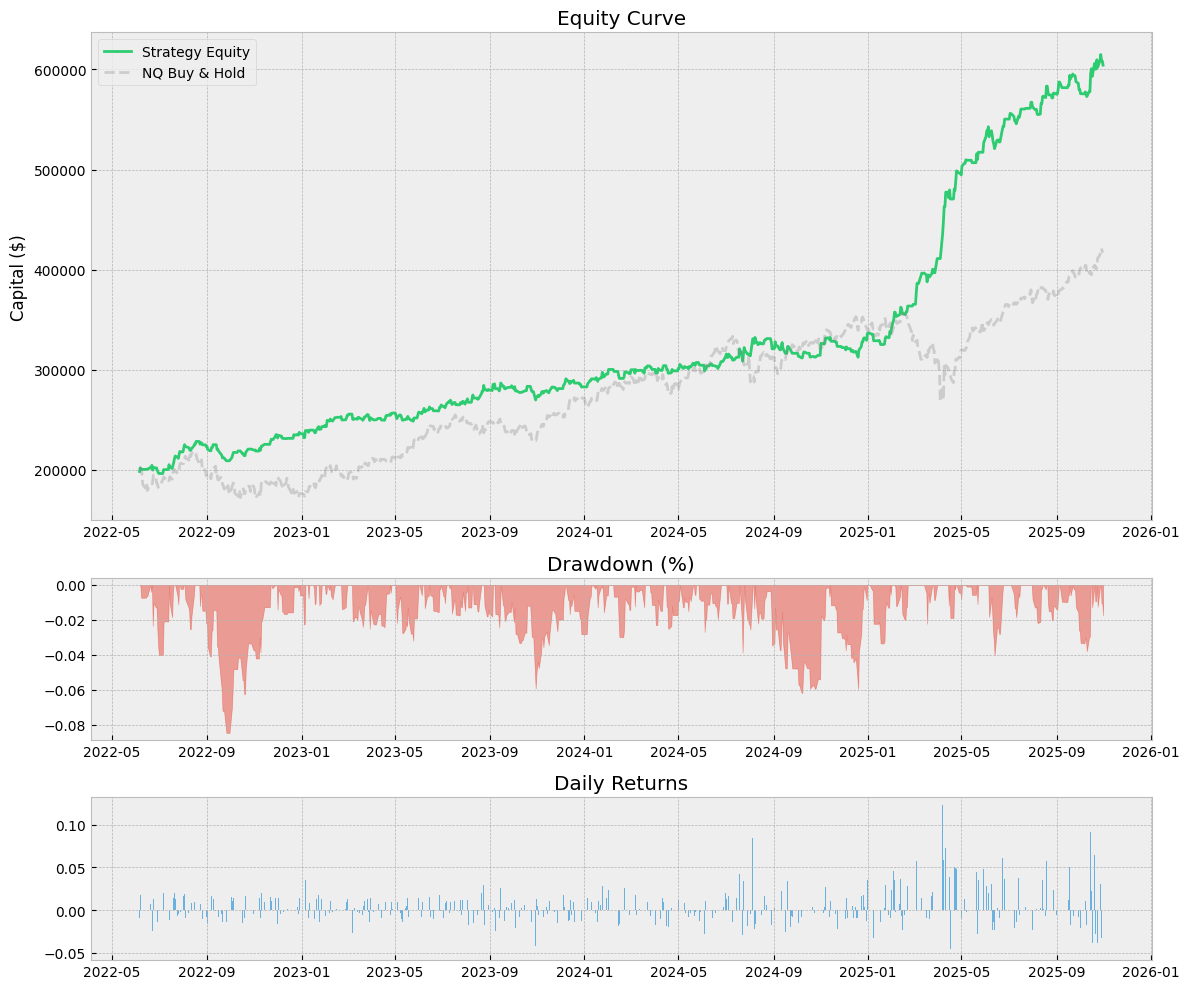

In [6]:
run_strategy()

## **6. Conclusion & Future Work**
The **Kintoun Strategy** demonstrates significantly improved expectancy and risk-adjusted return, as well as lower max drawdown compared to a naive breakout strategy. Using Volume, VWAP, and slope ensures we are not trading against the dominant intraday flow.

**Future Improvements:**  
- **Execution:** Moving from ```close``` prices to Tick Data to better model slippage on stop orders.  
- **Optimization:** Exploring a machine learning approach (Random Forest, XGBoost) to classify the probability of a successful retest/trade.
